In [2]:
import os
#import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image

In [3]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = pathlib.Path(os.path.join(base_dir, 'datasets/images/'))
print(f'datasets directory: {dataset_dir}')

current directory: /Users/alicialarsen/Documents/TUe/Honors/MedAI/replicate-BSc-Thesis
datasets directory: /Users/alicialarsen/Documents/TUe/Honors/MedAI/replicate-BSc-Thesis/datasets/images


In [4]:
image_count = len(list(dataset_dir.glob('**/*.png')))
print('number of total images:', image_count, '\n\n')

number of total images: 50 




In [5]:
batch_size = 5
img_height = 1108
img_width = 1488

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 50 files belonging to 2 classes.
Using 40 files for training.


Found 50 files belonging to 2 classes.
Using 10 files for validation.
['a', 'b']


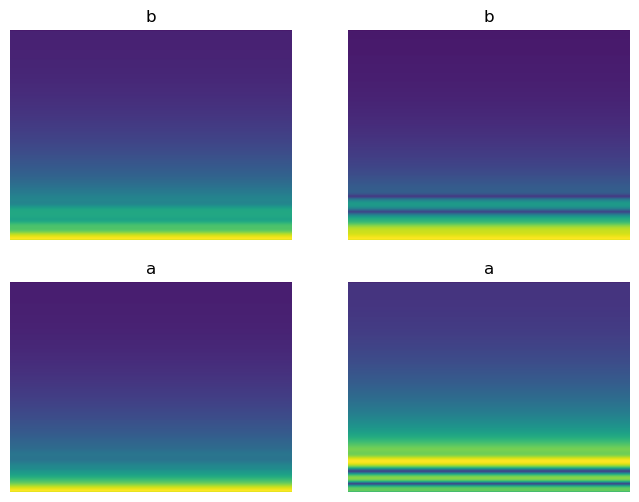

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(5, 1108, 1488, 3)
(5,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

####**CNN classification with a simple model**

In [10]:
num_classes = len(class_names)

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


simple_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1)

8/8 [==============================] - 120s 15s/step - loss: 0.6990 - accuracy: 0.4500 - val_loss: 0.6937 - val_accuracy: 0.4000


####**CNN classification with a VGG-16 model**

In [11]:
"""num_classes = len(class_names)

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(1108, 1488, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(num_classes, activation="softmax"))
vgg16_model.summary()

opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg16_model.fit(train_ds, validation_data=val_ds, epochs=3)"""

'num_classes = len(class_names)\n\nvgg16_model = keras.Sequential()\nvgg16_model.add(layers.Conv2D(input_shape=(1108, 1488, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nvgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))\nvgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))\nvgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nvgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))\nvgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))\nvgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nvgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nvgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))\nvgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))\nvgg16_model.

In [12]:
models_path = os.path.join(base_dir, 'models')
#vgg16_model.save(os.path.join(models_path, 'vgg16_model.h5'))
simple_model.save(os.path.join(models_path, 'simple_model.h5'))

/Users/alicialarsen/anaconda3/envs/MedAI/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


use `model = keras.models.load_model('path/to/location')` to load the models

In [13]:
simple_model = keras.models.load_model(os.path.join(models_path, 'simple_model.h5')) 
#vgg16_model = keras.models.load_model(os.path.join(models_path, 'vgg16_model.h5')) 

In [14]:
tf.keras.utils.plot_model(simple_model, dpi=75)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
# tf.keras.utils.plot_model(vgg16_model)

**Evaluations**

In [16]:
def evaluate(model, name='model'):
  loss, acc = model.evaluate(val_ds, batch_size= batch_size)
  print(f"{name}'s accuracy: {round((acc * 100), 2)}%")

evaluate(simple_model, 'simple CNN')
# evaluate(vgg16_model, 'VGG-16')

2/2 [==============================] - 4s 2s/step - loss: 0.6937 - accuracy: 0.4000
simple CNN's accuracy: 40.0%


In [17]:
def predict(model):
  return np.argmax(model.predict(val_ds), axis=-1)

def get_labels(dataset, batch_count=2):
  lst = []
  for im, label in val_ds.take(2):
    lst.extend(label.numpy())
  return np.array(lst)

# vgg16_comparison_list = list(zip(predict(vgg16_model), get_labels(val_ds)))
simple_comparison_list = list(zip(predict(simple_model), get_labels(val_ds)))
#print("VGG-16 (predictions, true labels): ", vgg16_comparison_list)
#print("simple model (predictions, true labels): ", vgg16_comparison_list)

2/2 [==============================] - 3s 1s/step
